# Principal Component Analysis

```
Dustin Michels
Nov 2017
```

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

from sklearn.decomposition import PCA
from scipy import stats

## Load Data

In [2]:
# This set the level of taxonomic analysis
TAXON_LVL = 3

# This runs the data_cleaning jupyter notebook,
# giving us accessing to variables created over there.
%run load_data.ipynb

In [3]:
# This is for storing images in the right folder
lvl = f"lvl{TAXON_LVL}"
lvl

'lvl3'

In [4]:
# Load approporate DFs, using newly loaded vars/ fcns

go_df = get_top_n(full_go, by_col='read_percent', n=25)
go_df = truncate_names(go_df)
tax_df = get_top_n(full_tax, by_col='tax_percent', n=10)

## Define Functions PCA / Plotting

In [5]:
def make_pca_df(data_df, vals='read_percent'):
    df = data_df.pivot(
        index='run_id', columns='name', values=vals)
    df.sort_index()
    return df

def do_PCA(pca_df, n=2):
    data = pca_df.as_matrix()
    pca = PCA(n_components=n)
    pca_array = pca.fit_transform(data)
    return pca_array
    
def make_plot_df(pca_df, n=2):
    
    # Do PCA
    pca_array = do_PCA(pca_df, n=n)
    
    # Add data to new DF, with metadata
    df = meta_df.set_index('run_id')
    df.sort_index(inplace=True)
    for i in range(pca_array.shape[1]):
        df.insert(i, f'PC{i+1}', pca_array[:,i])
    
    # Tidy up DF
    df['region'] = df['region'].map(region_map)
    df['zone'] = df['zone'].map(zone_map)
    df = df.drop('filename', axis=1)
    df.reset_index(inplace=True)    
    return df

def make_pca_plot(data, hue='region', filename='my_pca_plot'):
    
    g = sns.lmplot(
        'PC1','PC2', data=data,
        fit_reg=False, hue=hue)
    g.savefig(f'{img_path}pca/{filename}.png')

## Make Plots of PC1 vs. PC2

### GO

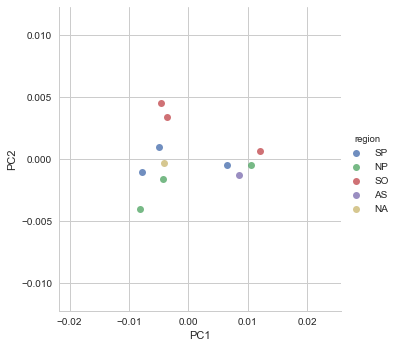

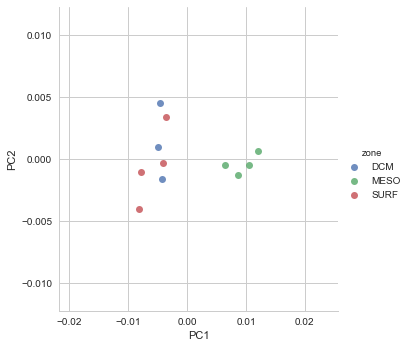

In [6]:
go_pca_df = make_pca_df(go_df, vals='read_percent')
go_pca_df = make_pca_df(go_df, vals='read_percent')
go_plot_df = make_plot_df(go_pca_df)

# hue = region
make_pca_plot(
    go_plot_df, hue='region',
    filename='go/pca_go_region')

# hue = zone
make_pca_plot(
    go_plot_df, hue='zone',
    filename='go/pca_go_zone')

### Taxonomy

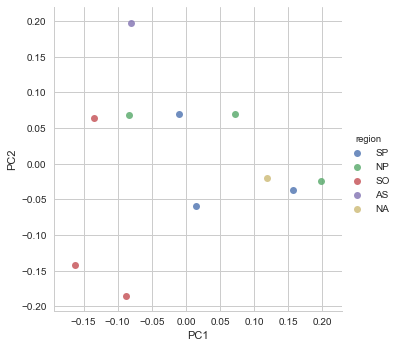

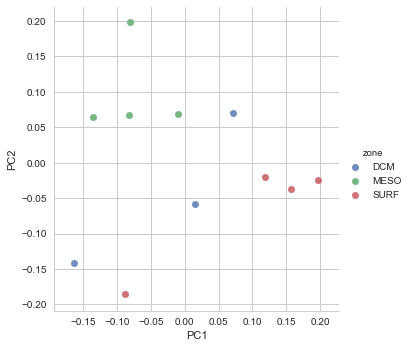

In [7]:
tax_pca_df = make_pca_df(tax_df, vals='tax_percent')
tax_plot_df = make_plot_df(tax_pca_df)

# hue = region
make_pca_plot(
    tax_plot_df, hue='region',
    filename=f'tax/{lvl}/pca_tax_region')

# hue = zone
make_pca_plot(
    tax_plot_df, hue='zone',
    filename=f'tax/{lvl}/pca_tax_zone')

## Joint Plots

### Define Functions

In [8]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [9]:
def make_jointplot(df, y_val='depth_(m)', filename='my_jointplot'):
    f = sns.jointplot(
        x='PC1', y=y_val, data=df,
        kind='reg', stat_func=r2)
    f.savefig(
        f'{img_path}pca-joint/{filename}',
        bbox_inches='tight', dpi=250)

In [10]:
# copy each item in list, remove lat and long
categories = meta_headers[:]
categories.remove('lat')
categories.remove('long')

### GO

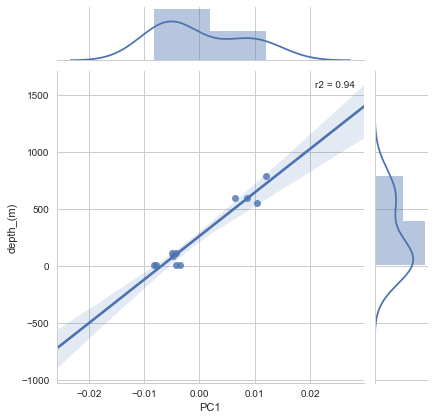

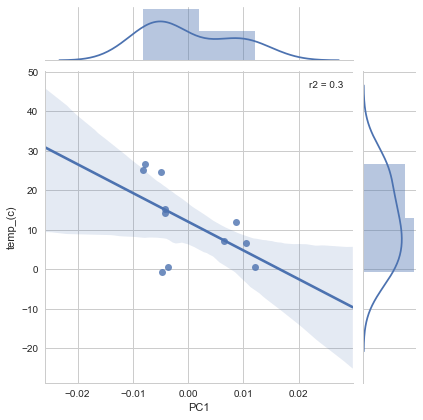

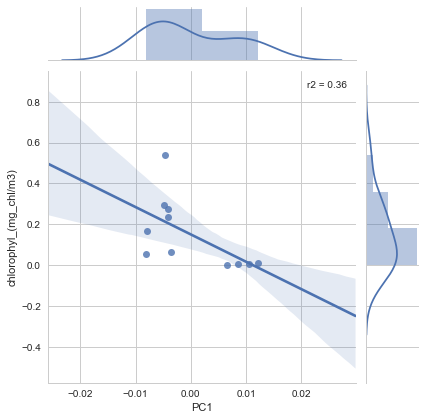

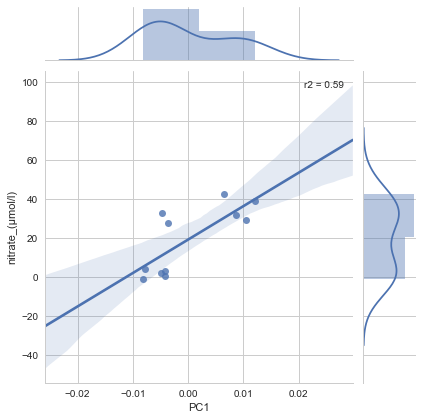

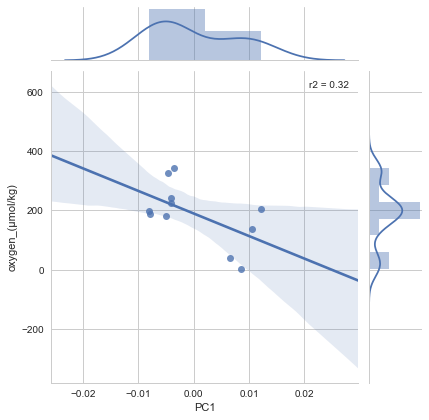

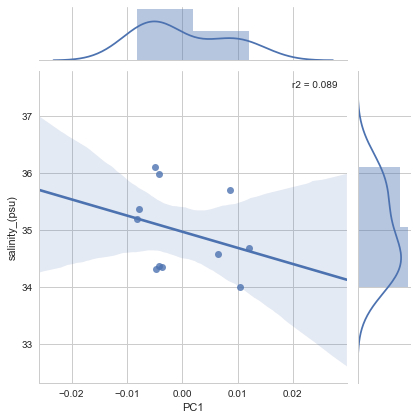

In [11]:
for val in categories:
    
    # grab part of word b/f first underscore
    name = val[:val.find('_')]
    
    make_jointplot(
        go_plot_df, y_val=val,
        filename=f'go/joint_go_PC_vs_{name}')

### Taxonomy

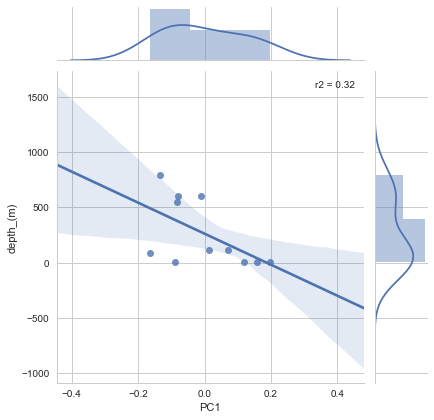

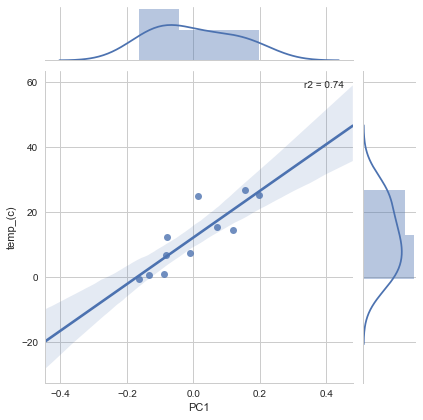

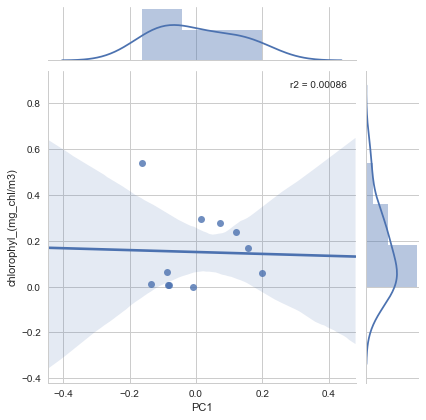

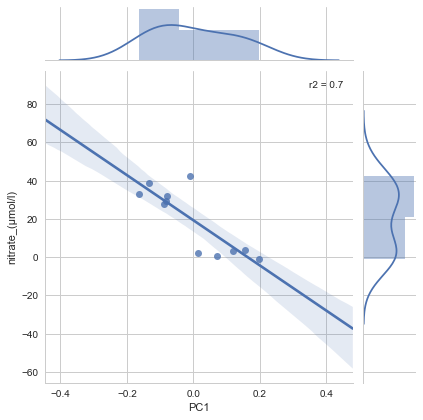

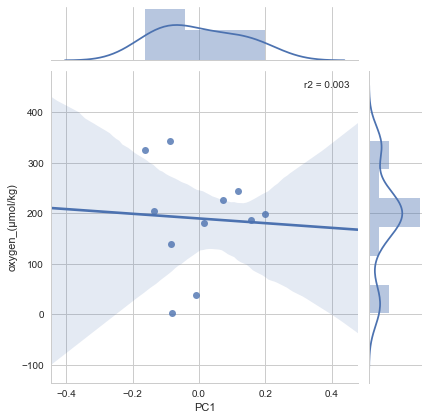

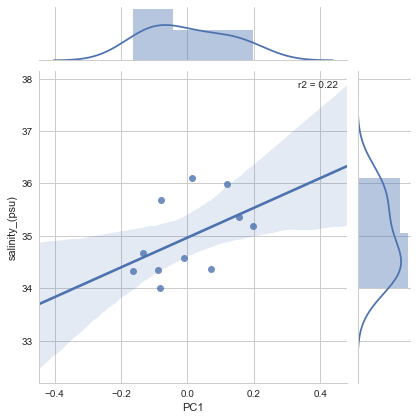

In [12]:
for val in categories:
    
    # grab part of word b/f first underscore
    name = val[:val.find('_')]
    
    make_jointplot(
        tax_plot_df, y_val=val,
        filename=f'tax/{lvl}/joint_tax_PC_vs_{name}')

## Pairplot

In [13]:
# Make new DF, dropping some values

drop_vals = [
    'run_id', 'PC1', 'PC2', 'lat', 'long',
    'nitrate_(µmol/l)','chlorophyl_(mg_chl/m3)']

go_pair_df = go_plot_df.drop(drop_vals, axis=1)

### Regression Pairplot

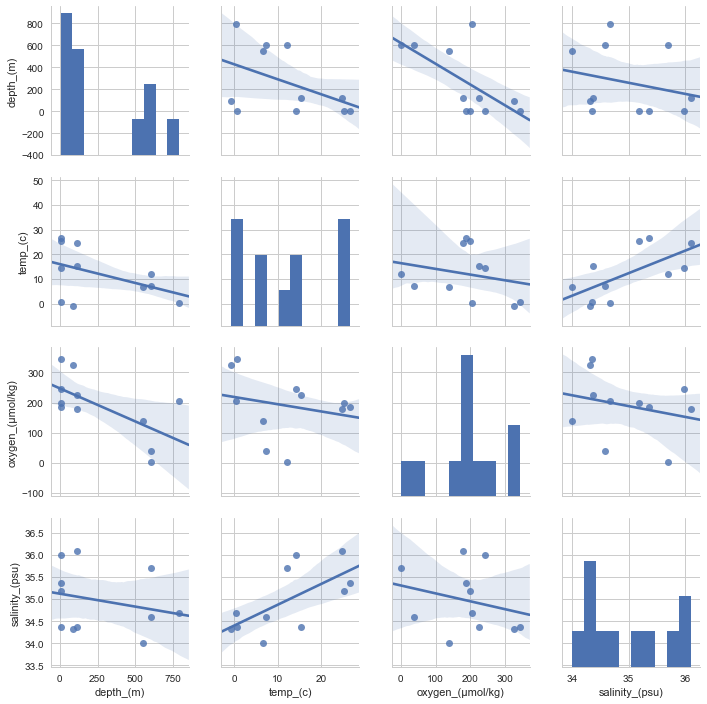

In [14]:
f = sns.pairplot(go_pair_df, kind='reg')

f.savefig(
    f'{img_path}pca-pair/pair_reg.png',
    bbox_inches='tight', dpi=250)

In [15]:
# Calculate r2 values

cols = go_pair_df.columns

for i in range(2,6):
    for j in range(i+1, 6):
        
        x = go_pair_df.iloc[:,i]
        y = go_pair_df.iloc[:,j]

        res = stats.linregress(x,y)
        r2 = res.rvalue**2
        
        print(f'{cols[i]} vs {cols[j]}')
        print(r2)
        print()

depth_(m) vs temp_(c)
0.208499981257

depth_(m) vs oxygen_(µmol/kg)
0.415822282866

depth_(m) vs salinity_(psu)
0.0594461276464

temp_(c) vs oxygen_(µmol/kg)
0.0553331974987

temp_(c) vs salinity_(psu)
0.429270175465

oxygen_(µmol/kg) vs salinity_(psu)
0.0643256852815



### Pairplot, with `zone` as hue

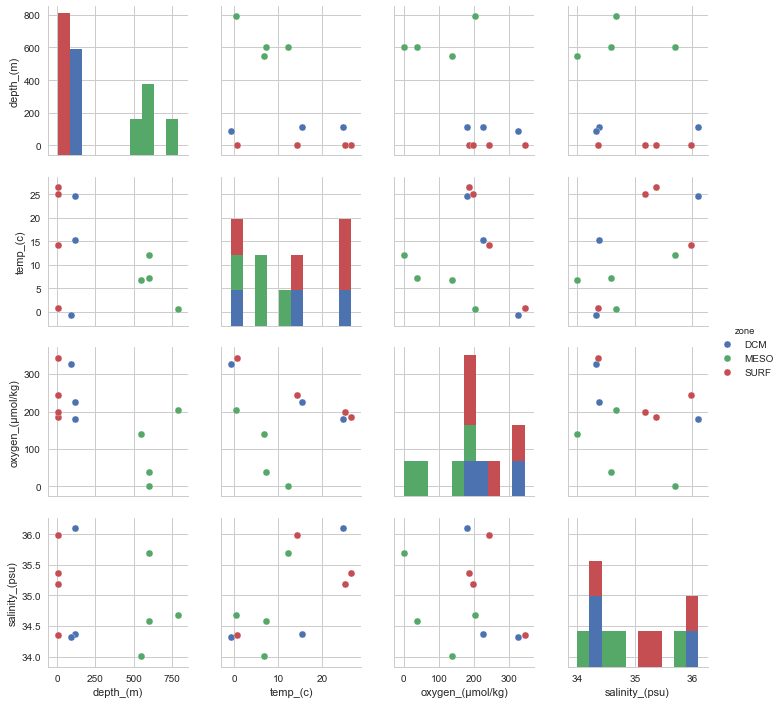

In [16]:
f = sns.pairplot(go_pair_df, hue='zone')

f.savefig(
    f'{img_path}pca-pair/pair_zone.png',
    bbox_inches='tight', dpi=250)

## 3D

In [17]:
# from mpl_toolkits import mplot3d

# pca = PCA(n_components=3)
# projected = pca.fit_transform(data)

# ax = plt.axes(projection='3d')

# x = projected[:,0]
# y = projected[:,1]
# z = projected[:,2]

# ax.scatter3D(x, y, z, c=region_codes)